Example Notebook of Multimodal Retrieval

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import timm
import json
from skimage import exposure
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model
import wfdb
import scipy
import scipy.signal
from scipy.signal import resample_poly

In [2]:
import sys
sys.path.append('./utils')
from build_model import ViTModelXray, ViTModelEcg, ProjectionHead

In [3]:
from transformers import AutoModel, AutoConfig, RobertaTokenizerFast, AutoTokenizer

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Enable parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
data_new = np.load('./data/xray_ecg_notes_labels_combined_60days.npy', allow_pickle = True)

In [6]:
test_data = [item for item in data_new if item[6] == 'test']

In [47]:
len(test_data)

17797

In [159]:
test_dict = {}
for item in test_data:
    key = item[0]

    test_dict[key] = item

In [160]:
test_data_new = list(test_dict.values())

In [164]:
test_data_new = np.squeeze(test_data_new)

In [165]:
import random
random.seed(42)
# Calculate 10% of the length of the indices list
ten_percent = int(len(test_data_new) * 0.4)

# Randomly select 10% of the indices
test_10 = random.sample(test_data , ten_percent)

In [133]:
def baseline_wander_removal(data, sampling_frequency = 100):
    row,__ = data.shape
    processed_data = np.zeros(data.shape)
    for lead in range(0,row):
        # Baseline estimation
        win_size = int(np.round(0.2 * sampling_frequency)) + 1
        baseline = scipy.signal.medfilt(data[lead,:], win_size)
        win_size = int(np.round(0.6 * sampling_frequency)) + 1
        baseline = scipy.signal.medfilt(baseline, win_size)
        # Removing baseline
        filt_data = data[lead,:] - baseline
        processed_data[lead,:] = filt_data
    return processed_data

class MultiModalData(Dataset):
    def __init__(self, data, phase = 'train'):
        self.data = data
        self.tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

        self.val_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.499], [0.293])
        ])

        self.phase = phase
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        xray = self.preprocess_xray(self.data[idx][0])
        ecg = self._load_ecg(self.data[idx][1])
        xray_note = self.data[idx][2]
        ecg_note = self.data[idx][3]
        note = self.encode_note(xray_note, ecg_note)

        return xray, ecg, note['input_ids'].squeeze(0), note['attention_mask'].squeeze(0)
        
    def preprocess_xray(self, x):
        x = Image.open(x)
        x = x.convert('L')
        x = x.resize((224,224))
        x = np.array(exposure.equalize_adapthist(x/np.max(x)))
        x = x *255 
        x = x.astype(np.uint8)
        x = Image.fromarray(x)
        if self.phase == 'train':
            x = self.xray_transforms(x)
        else:
            x = self.val_transforms(x)
        
        return torch.cat([x,x,x], dim = 0)
    
    def _load_ecg(self, x):
        x = wfdb.rdsamp(x)[0]
        nan_indices = np.argwhere(np.isnan(x))
        x[np.isnan(x)] = 0
        x = resample_poly(x, up = 1, down = 5, axis = 0)
        x = np.transpose(x, (1,0))
        x = baseline_wander_removal(x, 100)
        x = self.normalize_per_lead(x)
        
        if self.phase == 'train':
            x = torch.from_numpy(x).float()
        else:
            x = torch.from_numpy(x).float()
            
        return x
    
    def normalize_per_lead(self,ecg_data):
        normalized_data = np.zeros_like(ecg_data, dtype=float)

        # Iterate over each lead
        for i in range(ecg_data.shape[0]):
            lead_data = ecg_data[i, :]
            min_val = np.min(lead_data)
            max_val = np.max(lead_data)

            epsilon = 1e-10
            normalized_lead = (2 * (lead_data - min_val) / (max_val - min_val + epsilon)) - 1

            # Assign normalized lead data to the corresponding row in the output array
            normalized_data[i, :] = normalized_lead

        return normalized_data
    
    def encode_note(self, x, y):
        if x and y:
            return self.tokenizer(x,y, return_tensors="pt", add_special_tokens = True, max_length=512, padding="max_length", \
                                  truncation=True, return_attention_mask=True)
        if x:
            return self.tokenizer(x, return_tensors="pt", max_length=128, padding="max_length", \
                                  truncation=True, return_attention_mask=True)
        if y:
            return self.tokenizer(y, return_tensors="pt", max_length=128, padding="max_length", \
                                  truncation=True, return_attention_mask=True)
        

In [24]:
def ecg_plot(array):
    #To reconstruct the 12 lead ecg from the array
    lead_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    plt.rcParams["figure.figsize"] = [12,9]
    fig, axs = plt.subplots(len(lead_order))
    if array.shape == (1000, 12):
        for i in range(0,12):
            axs[i].plot(array[:,i])
            axs[i].set(ylabel=str(lead_order[i]))
    elif array.shape == (12, 1000):
        for i in range(0,12):
            axs[i].plot(array[i,:])
            axs[i].set(ylabel=str(lead_order[i]))
    elif array.shape == (1,1000,12):
        for i in range(0,12):
            axs[i].plot(array[:,i])
            axs[i].set(ylabel=str(lead_order[i]))
    else:
        print("ECG shape not valid: ",array.shape)
    plt.show()

In [167]:
test = MultiModalData(test_10, 'val')

In [168]:
test_loader = DataLoader(test, batch_size = 36, num_workers = 7, shuffle=False)

In [88]:
class MultiModal(nn.Module):
    def __init__(self):
        super(MultiModal, self).__init__()

        config = AutoConfig.from_pretrained(
                "./data/RoBERTa-base-PM-M3/RoBERTa-base-PM-M3-hf",
            )
        self.text_model = AutoModel.from_pretrained("./data/RoBERTa-base-PM-M3/RoBERTa-base-PM-M3-hf", config=config)

        lora_config = LoraConfig(
            r=16,
            # target_modules = target_modules,
            lora_alpha=8,
            lora_dropout=0.1,
            bias="all",
            task_type="FEATURE_EXTRACTION",
        )
        self.text_model = get_peft_model(self.text_model, lora_config)
        self.ecg_model = ViTModelEcg(projector = False)
        self.xray_model = ViTModelXray(projector = False)

        self.projector_xray_text = ProjectionHead(768, 128, 768)
        self.projector_ecg_text = ProjectionHead(768, 128, 768)    
        
        self.projector_text = ProjectionHead(768, 128, 768)
        
    def forward(self, xray, ecg, note_id, mask):
        ecg_out = self.ecg_model(ecg)
        ecg_p_text = self.projector_ecg_text(ecg_out)

        xray_out = self.xray_model(xray)
        xray_p_text = self.projector_xray_text(xray_out)
        
        note_out = self.text_model(note_id, attention_mask=mask).last_hidden_state.mean(dim=1)
        note_p = self.projector_text(note_out)
        
        return xray_p_text, ecg_p_text, note_p


In [89]:
model = MultiModal()

In [13]:
model

MultiModal(
  (ecg_model): ViTModelEcg(
    (vit_model): ViTWithDropKey(
      (patch_embed): PatchEmbed(
        (conv1): Sequential(
          (0): Conv1d(12, 256, kernel_size=(5,), stride=(5,))
          (1): ReLU()
          (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Sequential(
          (0): Conv1d(256, 768, kernel_size=(5,), stride=(1,))
          (1): ReLU()
          (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=False)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): D

In [90]:
model_dict = torch.load('./saved_models/best_mulitmodal.pth')

In [91]:
model.load_state_dict(model_dict)

<All keys matched successfully>

In [128]:
def get_feature_embeddings(val_loader, model):

    model.cuda()
    model.eval()

    xray_embeddings = []
    ecg_embeddings = []
    with torch.no_grad():
        for xray, ecg, _, _ in tqdm(val_loader):
            xray, ecg = xray.cuda(), ecg.cuda()
            with autocast():
                image_features = model.projector_xray_text(model.xray_model(xray))
                ecg_features = model.projector_ecg_text(model.ecg_model(ecg))
                xray_embeddings.append(image_features)
                ecg_embeddings.append(ecg_features)

    return torch.cat(xray_embeddings), torch.cat(xray_embeddings)

In [169]:
xray_features, ecg_features = get_feature_embeddings(test_loader, model)

100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


In [130]:
xray_features.shape

torch.Size([1094, 128])

In [41]:
def find_matches(model, feature_embeddings, query, data_split, n = 5, retrieval = 'xray'):
    labels = []
    model.eval()
    if retrieval == 'ecg':
        query_encoded = test.preprocess_xray(query)
        with torch.no_grad():
            with autocast():
                xray_feature = model.xray_model(query_encoded.unsqueeze(0).cuda())
                query_embedding = model.projector_xray_text(xray_feature)
    else:
        query_encoded = test._load_ecg(query)
        with torch.no_grad():
            with autocast():
                query_embedding = model.ecg_model(query_encoded.unsqueeze(0).cuda())
                query_embedding = model.projetor_ecg_text(query_embedding)
                

    feature_embeddings_n = F.normalize(feature_embeddings, dim = -1)
    query_embeddings_n = F.normalize(query_embedding, dim = -1)
    dot_similarity = query_embeddings_n @ feature_embeddings_n.T

    # values, indices = torch.topk(dot_similarity.squeeze(0), n5)
    values, indices = torch.topk(dot_similarity.squeeze(0), n*3)
    # print(indices)
    matches = [(data_split[idx][0], data_split[idx][1], data_split[idx][2], data_split[idx][3]) for idx in indices[::3]]
    labels.extend([data_split[idx][5] for idx in indices[::3]])
    # labels.extend([data_split[idx][2] for idx in indices])

    _, axes = plt.subplots(int(n/2), int(n/2), figsize=(7, 7))
    for i, ((xray, ecg, text1, text2), ax) in enumerate(zip(matches, axes.flatten())):
        # image = Image.open(img).convert('L').resize((224,224))
        print(f'text for image: {i+1}')
        print(text1)
        print(text2)
        print('-'*40)
        ecg_plot(test._load_ecg(ecg))
        ax.axis("off")
    # plt.savefig('grid_image.png')
    plt.show()
    
    return np.stack(labels)

In [171]:
def find_matches(model, xray_embeddings, ecg_embeddings, query1, query2, data_split, n = 5):
    labels_xray = []
    labels_ecg = []
    model.eval()
    tokenizer = test.tokenizer
    encoded_query = test.encode_note(query1, query2)
    batch = {
        key: torch.tensor(values).cuda()
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        with autocast():
            text_features = model.text_model(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            ).last_hidden_state.mean(dim=1)

            query_embedding = model.projector_text(text_features)
            

    xray_embeddings_n = F.normalize(xray_embeddings, dim = -1)
    ecg_embeddings_n = F.normalize(ecg_embeddings, dim = -1)
    query_embeddings_n = F.normalize(query_embedding, dim = -1)
    dot_similarity_xray = query_embeddings_n @ xray_embeddings_n.T
    dot_similarity_ecg = query_embeddings_n @ ecg_embeddings_n.T

    # values, indices = torch.topk(dot_similarity.squeeze(0), n5)
    values, indices_xray = torch.topk(dot_similarity_xray.squeeze(0), n*5)
    values, indices_ecg = torch.topk(dot_similarity_ecg.squeeze(0), n*5)
    # print(indices)
    matches_xray = [(data_split[idx][0], data_split[idx][1], data_split[idx][2]) for idx in indices_xray[::5]]
    matches_ecg = [(data_split[idx][0], data_split[idx][1], data_split[idx][3]) for idx in indices_ecg[::5]]
    labels_xray.extend([data_split[idx][5] for idx in indices_xray[::5]])
    labels_ecg.extend([data_split[idx][5] for idx in indices_ecg[::5]])

    _, axes = plt.subplots(int(n/2), int(n/2), figsize=(7, 7))
    for i, ((xray, ecg, text), ax) in enumerate(zip(matches_xray, axes.flatten())):
        image = Image.open(xray).convert('L').resize((224,224))
        print(f'text for image: {i+1}')
        print(text)
        print('-'*40) 
        ax.imshow(image)
        ax.axis("off")
    # plt.savefig('grid_image.png')
    plt.show()
    
    for i, (xray, ecg, text) in enumerate(matches_ecg):
        print(f'text for ecg: {i+1}')
        print(text)
        print('-'*40)
        ecg_plot(test._load_ecg(ecg))
        
    
    
    return np.stack(labels_xray), np.stack(labels_ecg)

/scratch/svthapa/1322804/ipykernel_1589382/760811085.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values).cuda()


text for image: 1
The report from Xray is:  PA and lateral chest compared to and : Moderate cardiomegaly has improved. Combination of mediastinal fat and possible middle lobe atelectasis should not be mistaken for pneumonia. Lungs are otherwise clear. There may be a very small new right pleural effusion. Thoracic aorta is generally large and tortuous but not focally aneurysmal. No evidence of tuberculosis.
----------------------------------------
text for image: 2
The report from Xray is:  No relevant change as compared to the previous image. Moderate cardiomegaly. Right PICC line. No pleural effusions. No pneumonia, no pulmonary edema.
----------------------------------------
text for image: 3
The report from Xray is:  There is a chronic diffuse interstitial abnormality, as seen on the CT from . Mild cardiomegaly is unchanged. Unchanged widening of the superior mediastinum is due to both mediastinal lipomatosis and tortuous vessels, as seen on the CT from . There is a small unchanged 

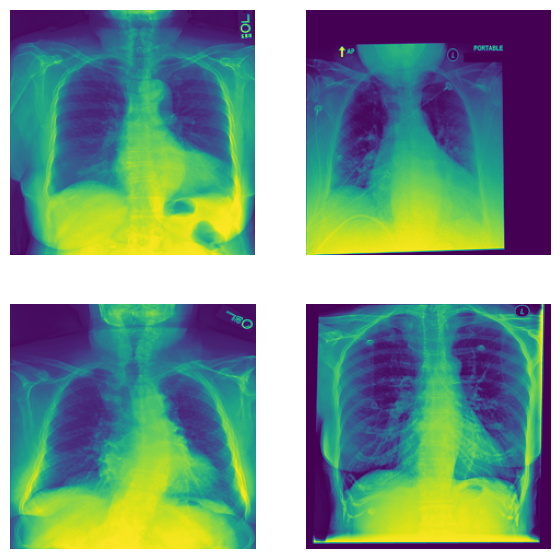

text for ecg: 1
The report from ECG is: Sinus bradycardia Normal ECG except for rate
----------------------------------------


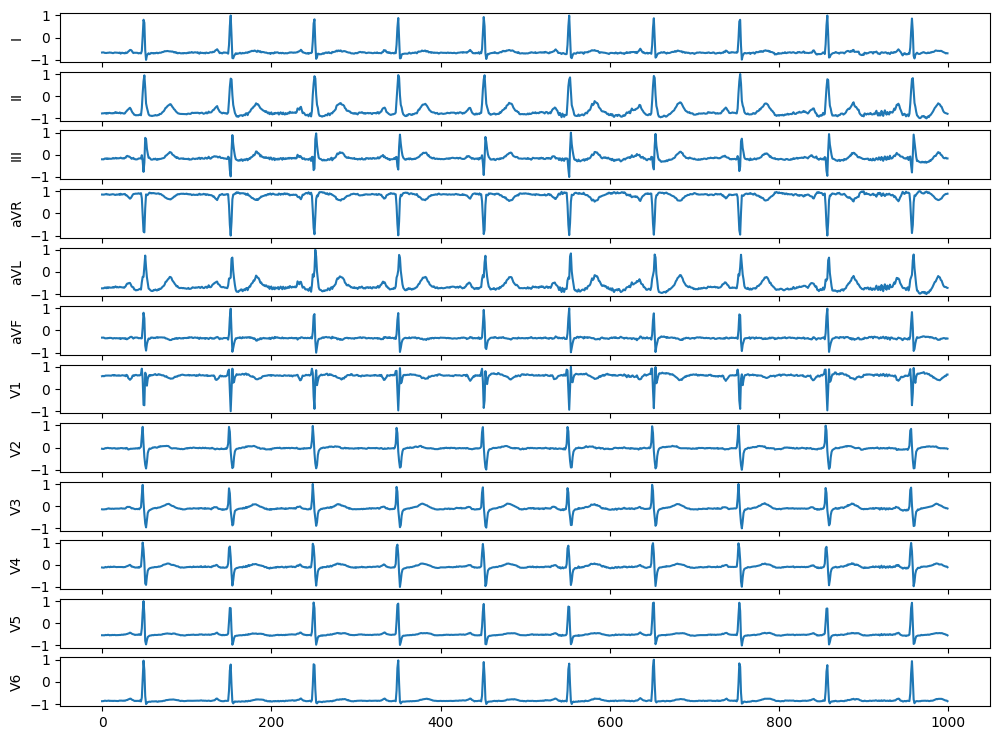

text for ecg: 2
The report from ECG is: SINUS RHYTHM PREMATURE VENTRICULAR CONTRACTION S PREMATURE ATRIAL CONTRACTION S Poor R wave progression V2 V4 PROBABLE NORMAL VARIANT Anterolateral T wave changes THESE MINOR CHANGES ARE OF EQUIVOCAL SIGNIFICANCE ONLY
----------------------------------------


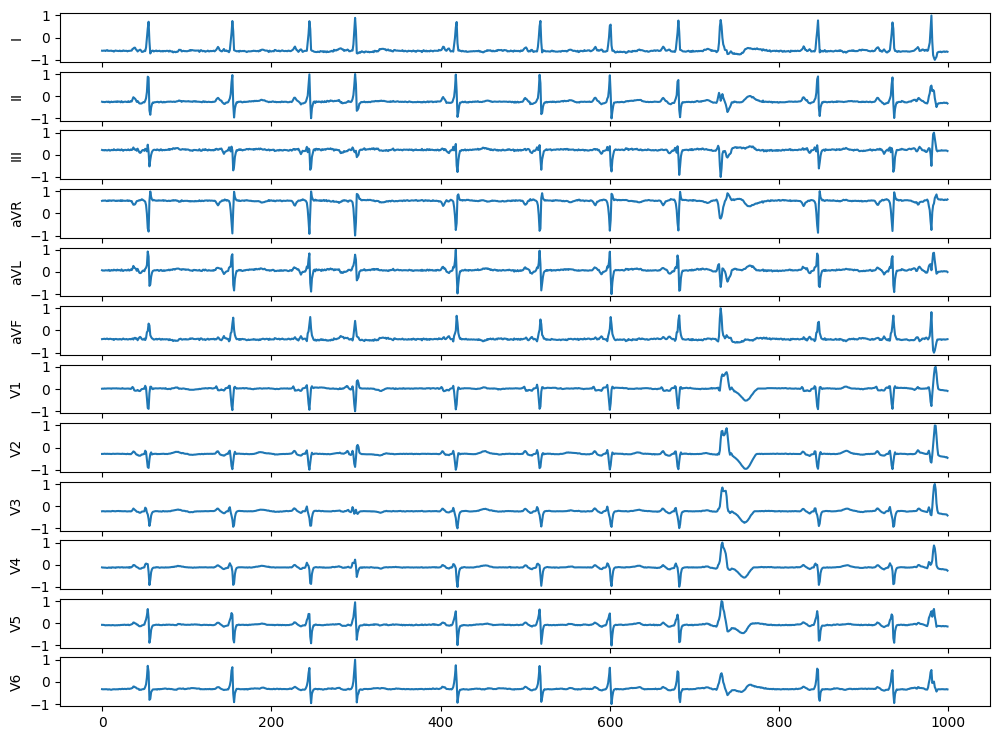

text for ecg: 3
The report from ECG is: Sinus bradycardia Prolonged QT interval Borderline ECG
----------------------------------------


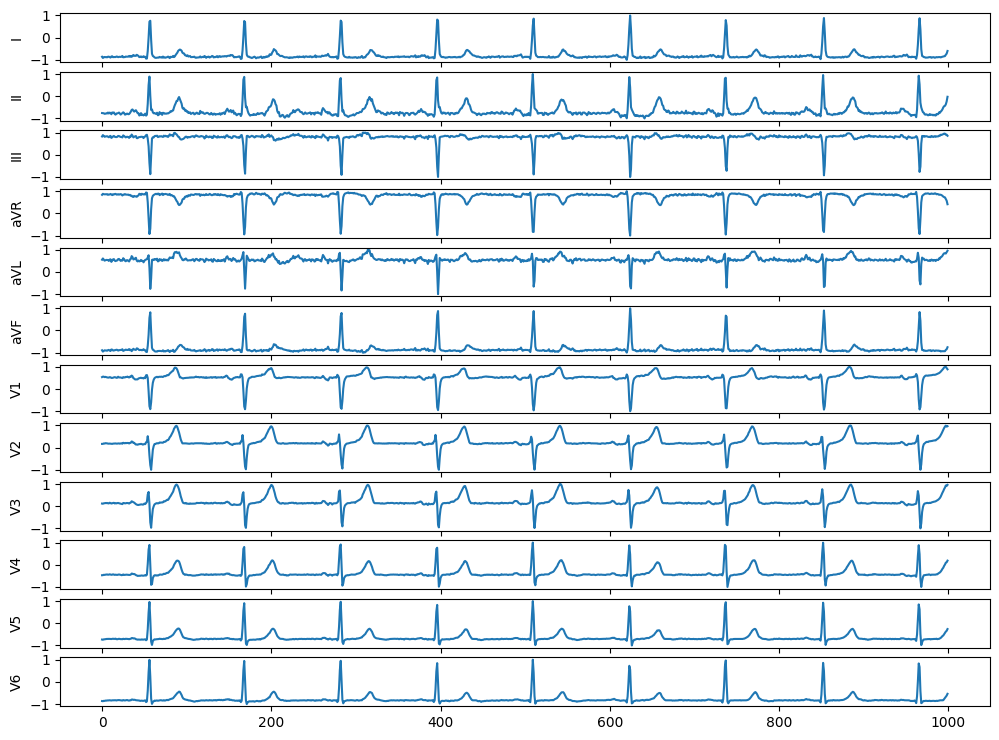

text for ecg: 4
The report from ECG is: Sinus rhythm with 1st degree A V block Possible anterior infarct age undetermined Lateral ST T changes may be due to myocardial ischemia Abnormal ECG
----------------------------------------


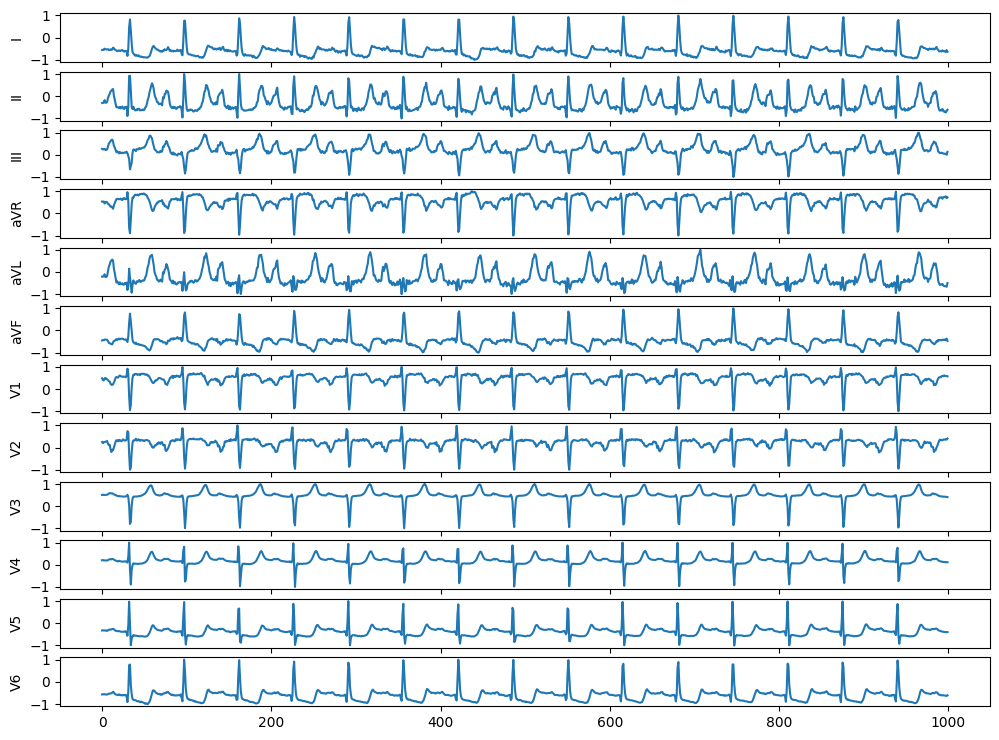

text for ecg: 5
The report from ECG is: Sinus arrhythmia. Possible left atrial abnormality rSr' V1 probable normal variant Poor R wave progression probable normal variant Anterolateral T wave changes are nonspecific Borderline ECG
----------------------------------------


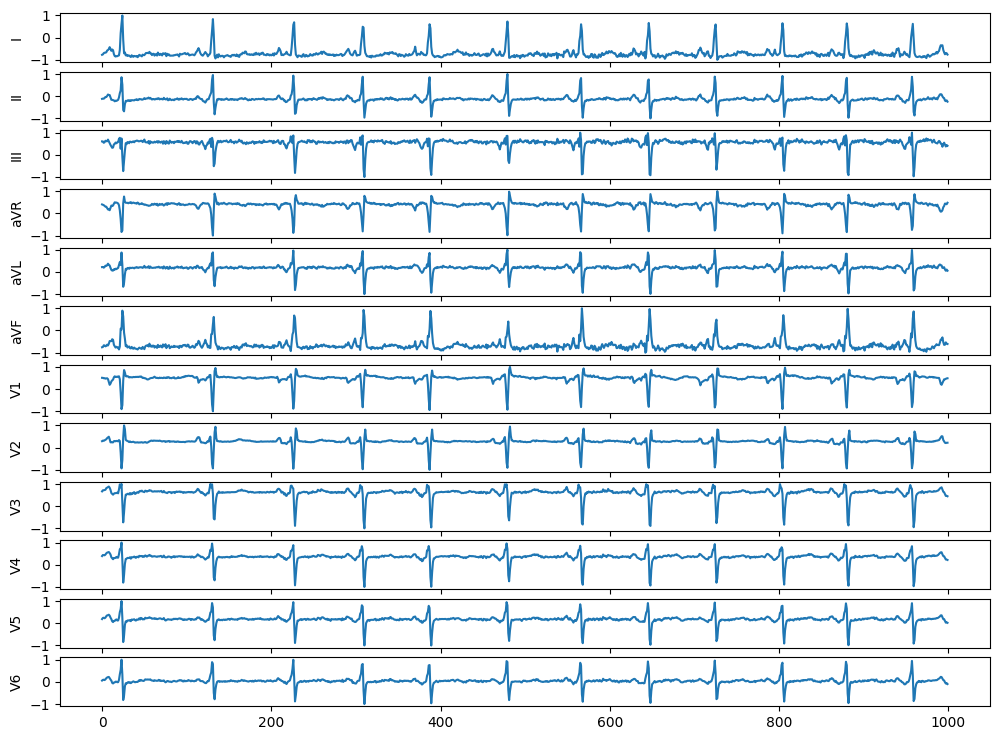

(array([[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0,
         0.0]], dtype=object),
 array([[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0,
         0.0]], dtype=object))

In [180]:
find_matches(model,
            xray_features,
            ecg_features,
            query1 = 'Cardiomegaly is present',
            query2=None,
            # query1 = test_10[5][2],
            # query2 = test_10[5][3],
            data_split = test_10,
            )